# Premier League ELO Rankings | 1993/94 - 2021/22

This project will attempt to create an ELO ranking system for all premier league teams based on their results since the 1993/94 season. This dataset has been downloaded from kaggle (link), and features no in depth stats before the 2000/01 season as these were not recorded beforehand. However, all that this system needs to function is the two teams playing and which team won (in this case: HomeTeam, AwayTeam and FTR). All teams will be given a base ELO of 800, and this value will change as it will normally in an ELO based ranking system.

The End goal is to provide a graph of the changes in ELO for each team, which will then be able to tell us interesting facts such as the best team in the last 20 years (will this be the Invincible Arsenal, Treble Winning Man Utd or Centurion Man City?), the worst team in the last 20 years, the times teams beat the ELO System (Leicster 2016?), and the rise and fall of certain teams (Man Utd, Arsenal, Blackburn, Notts Forrest). Obviously, this model will have some flaws, as certain small clubs that have since become large oil clubs will have slightly altered ELOS, but it should be interesting nonetheless. 

In [577]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime
from datetime import datetime
import re

In [578]:
#turn the csv file into a dataframe
results = pd.read_csv("C:/Users/mijma/OneDrive/Desktop/PremierLeagueProject/premierLeagueResults.csv", encoding = "Latin-1")

## Data Inspection and Organisation

In [579]:
print(results.head())

    Season              DateTime     HomeTeam        AwayTeam  FTHG  FTAG FTR  \
0  1993-94  1993-08-14T00:00:00Z      Arsenal        Coventry     0     3   A   
1  1993-94  1993-08-14T00:00:00Z  Aston Villa             QPR     4     1   H   
2  1993-94  1993-08-14T00:00:00Z      Chelsea       Blackburn     1     2   A   
3  1993-94  1993-08-14T00:00:00Z    Liverpool  Sheffield Weds     2     0   H   
4  1993-94  1993-08-14T00:00:00Z     Man City           Leeds     1     1   D   

   HTHG  HTAG  HTR  ... HST  AST  HC  AC  HF  AF  HY  AY  HR  AR  
0   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 23 columns]


In [580]:
print(results.columns)

Index(['Season', 'DateTime', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
       'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')


In [581]:
print(results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113 entries, 0 to 11112
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    11113 non-null  object 
 1   DateTime  11113 non-null  object 
 2   HomeTeam  11113 non-null  object 
 3   AwayTeam  11113 non-null  object 
 4   FTHG      11113 non-null  int64  
 5   FTAG      11113 non-null  int64  
 6   FTR       11113 non-null  object 
 7   HTHG      10189 non-null  float64
 8   HTAG      10189 non-null  float64
 9   HTR       10189 non-null  object 
 10  Referee   8289 non-null   object 
 11  HS        8289 non-null   float64
 12  AS        8289 non-null   float64
 13  HST       8289 non-null   float64
 14  AST       8289 non-null   float64
 15  HC        8289 non-null   float64
 16  AC        8289 non-null   float64
 17  HF        8289 non-null   float64
 18  AF        8289 non-null   float64
 19  HY        8289 non-null   float64
 20  AY        8289 non-null   fl

In [596]:
#setting up the ELO base values
matchDataHome = list(results.HomeTeam)
matchDataAway = list(results.AwayTeam)
matchDataFTR = list(results.FTR)
matchDataDate = (results['DateTime'].str.extract(r'(\d{4}-\d{2}-\d{2})')).values.tolist()



allTeams = results['HomeTeam'].unique()

eloDictionary = dict.fromkeys(allTeams, 800)

#these lists must be immutable
eloAllTime = {k:[] for k in allTeams}
allDates = {k:[] for k in allTeams}

In [597]:
def expectedResults(homeTeam, awayTeam):
    homeRating = eloDictionary[homeTeam]
    awayRating = eloDictionary[awayTeam]
    ratingDiff = homeRating - awayRating
    expectedResult = (1 / (10 ** (-ratingDiff/800)+1))
    
    return [np.round(expectedResult,3), 1 - np.round(expectedResult,3)]

def actualResult(team1, team2, FTR):
    homeTeam = 0.5
    awayTeam = 0.5
    if FTR == 'H':
        homeTeam = 1
        awayTeam = 0
    elif FTR == 'A':
        homeTeam = 0
        awayTeam = 1
        
    return [homeTeam, awayTeam]
    
def calculateElo(expected, actual, elo):
    k = 20
    
    newElo = elo + (k * (actual - expected))
    
    
    return newElo    
    
def gameDay(homeTeam, awayTeam, FTR):
    expected = expectedResults(homeTeam, awayTeam)
    actual = actualResult(homeTeam, awayTeam, FTR)
    
    #home team elo update
    eloDictionary[homeTeam] = int(calculateElo(expected[0], actual[0], eloDictionary[homeTeam]))
    
    
    #away team elo update
    eloDictionary[awayTeam] = round(calculateElo(expected[1], actual[1], eloDictionary[awayTeam]))
    
    
    
gameDay('Arsenal', 'Aston Villa', 'T')
print(eloDictionary['Arsenal'])
print(eloDictionary['Aston Villa'])

800
800


In [598]:
for i in range(len(matchDataHome)):
    gameDay(matchDataHome[i], matchDataAway[i], matchDataFTR[i])  
    eloAllTime[matchDataHome[i]].append(eloDictionary[matchDataHome[i]])  
    eloAllTime[matchDataAway[i]].append(eloDictionary[matchDataAway[i]])
    allDates[matchDataHome[i]].append(matchDataDate[i])
    allDates[matchDataAway[i]].append(matchDataDate[i])   

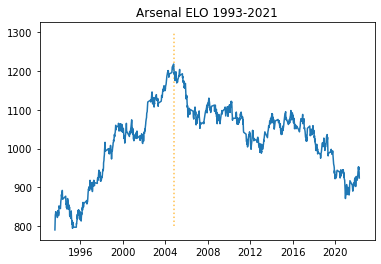

In [612]:
datetime.strptime('2004-10-24', '%Y-%m-%d').date()

ArsenalDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Arsenal']]
plt.plot(ArsenalDateObjects, eloAllTime['Arsenal'])
plt.vlines(datetime.strptime('2004-10-24', '%Y-%m-%d').date(), 800, 1300, color='orange', linestyle='dotted',
           alpha=0.7, label='Invincibles Run Ends')
plt.title('Arsenal ELO 1993-2021')
plt.show()

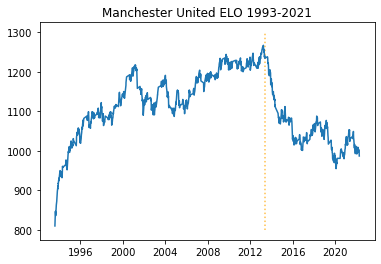

In [611]:
ManUtdDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Man United']]
plt.plot(ManUtdDateObjects, eloAllTime['Man United'])
plt.vlines(datetime.strptime('2013-05-08', '%Y-%m-%d').date(), 800, 1300, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Manchester United ELO 1993-2021')
plt.show()

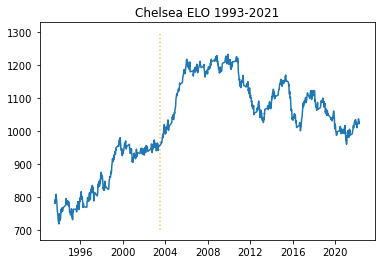

In [610]:
ChelseaDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Chelsea']]
plt.plot(ChelseaDateObjects, eloAllTime['Chelsea'])
plt.vlines(datetime.strptime('2003-07-02', '%Y-%m-%d').date(), 700, 1300, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Chelsea ELO 1993-2021')
plt.show()

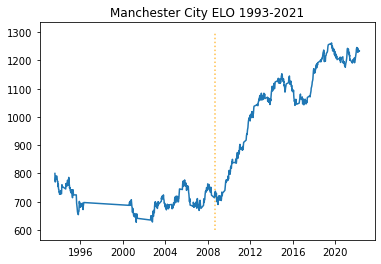

In [609]:
ManCityDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Man City']]
plt.plot(ManCityDateObjects, eloAllTime['Man City'])
plt.vlines(datetime.strptime('2008-09-01', '%Y-%m-%d').date(), 600, 1300, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Manchester City ELO 1993-2021')
plt.show()

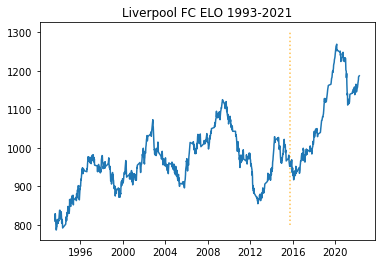

In [614]:
LiverpoolDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Liverpool']]
plt.plot(LiverpoolDateObjects, eloAllTime['Liverpool'])
plt.vlines(datetime.strptime('2015-10-09', '%Y-%m-%d').date(), 800, 1300, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Liverpool FC ELO 1993-2021')
plt.show()

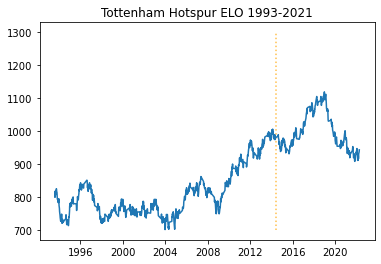

In [615]:
SpursDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Tottenham']]
plt.plot(SpursDateObjects, eloAllTime['Tottenham'])
plt.vlines(datetime.strptime('2014-05-27', '%Y-%m-%d').date(), 700, 1300, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Tottenham Hotspur ELO 1993-2021')
plt.show()

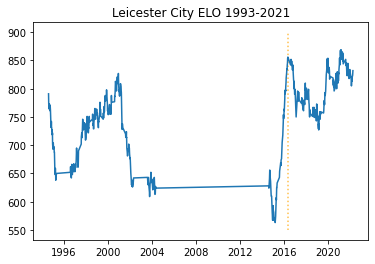

In [619]:
LeicesterDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Leicester']]
plt.plot(LeicesterDateObjects, eloAllTime['Leicester'])
plt.vlines(datetime.strptime('2016-05-27', '%Y-%m-%d').date(), 550, 900, color='orange', linestyle='dotted', alpha=0.7)
plt.title('Leicester City ELO 1993-2021')
plt.show()